TODO:  
- Improve comments particularly in the latter portion
- Improve transparency of variable names
- Make figure generation consistent
- The actual segments with regression / ridge regression need to have better comments above the code with variable names in the math that match the code.

# Ridge-regression (Regression + regularization) mini-tutorial

In this set of exercises we will try to predict the neural activity from videos of animal behavior using ridge-regression.  This particular group of neurons have been classified as NOT stimulus-selective, so we are interested in understanding what they are doing. The motivation for this regression analysis is to investigate whether the neural activity is explained by mouse behavior.

TODO: Add more context for where the data came from

Set up python packages and load data

In [48]:
# This cell imports all the functions and data we need.
import os # os stands for "operating system" and includes read/write routines etc. 
import numpy as np # by far the most used library for everyday computation
from scipy import io # this is for importing Matlab data files
from scipy import stats # here we import a whole sub-library of stats functions
from scipy.ndimage import gaussian_filter # here we import a single function for gaussian_filtering
from sklearn.decomposition import PCA # check out all the other dimensionality reduction methods in "decomposition"
from matplotlib import pyplot as plt # all of our plotting is done with plt
from scipy.stats import zscore
import urllib
%matplotlib inline 

# download 2-photon data
if not os.path.isfile('data/mesoscale.npy'):
    if not os.path.exists('data'):
        os.mkdir('data')
    with urllib.request.urlopen('http://www.gatsby.ucl.ac.uk/~cstringer/mesoscale.npy') as response:
        with open('data/mesoscale.npy','wb') as f:
            f.write(response.read())

data = np.load('data/mesoscale.npy',allow_pickle=True).item()

# Extract the data into variables
X = zscore(data['spks'], axis=1) # 2-photon neural activity with mean 0 and standard deviation, collected at 3Hz
xy_location = data['xyloc'] # xy location of the cell
behaviorSVD = data['behSVD'] # video of the mouse's face during behavior projected onto the top 500 principal components
del data

# 0) Explanation of data

number of neurons: 5439 ; number of timepoints: 10000


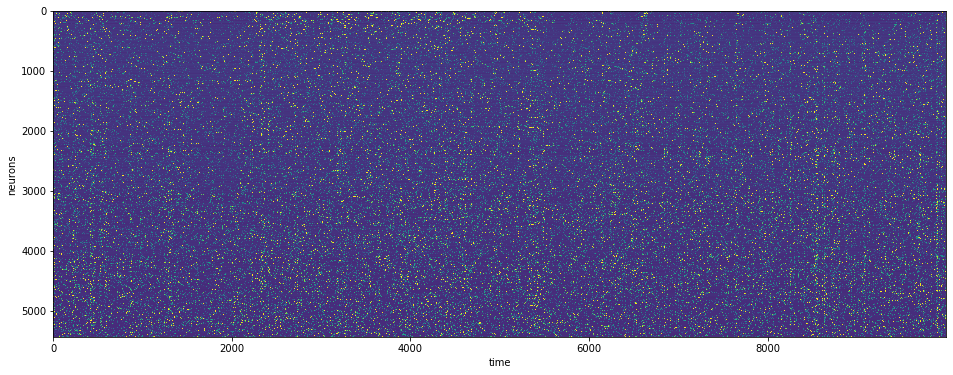

In [49]:
# X now contains the zscored 2-photon data in a matrix (nxt, where n is the # of neurons and t is the # of timepoints)
print('number of neurons: %d ; number of timepoints: %d'%(X.shape[0],X.shape[1]))

# visualize neural data in raster
fig=plt.figure(figsize=(16,6))
# add subplot to figure
ax = fig.add_subplot(111)
# plot spikes
# (imshow is like imagesc in matlab, with vmin and vmax setting range)
ax.imshow(X, vmin=-1, vmax=4, aspect='auto')
ax.set_xlabel('time')
ax.set_ylabel('neurons');

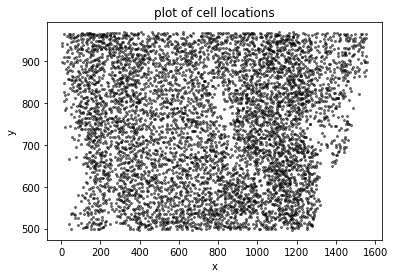

In [50]:
# visualize the cell locations (units??)
colors = [(0,0,0)]
plt.scatter(xy_location[:,0], xy_location[:,1], c=colors, alpha=0.5,s=4)
plt.title('plot of cell locations')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [10]:
# Visualize principal components
# TODO -- this isn't necessary but it might be nice for completeness

(500, 10000)


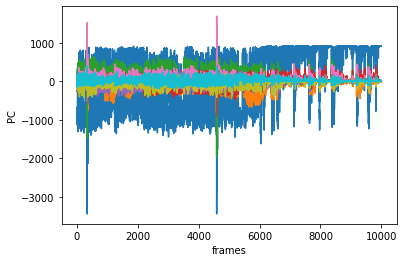

In [11]:
# Visualize behavioral data projected onto top 10 principal components (PCs)
print(behaviorSVD.shape)
plt.plot(behaviorSVD[0:10,:].T)
plt.xlabel('frames')
plt.ylabel('PC')
plt.show()

# 1) Prepare neural data (bin + PCA)

In [51]:
# First bin the neural activity and the behavior into 1 second bins.
tbin = int(3)
NT = behaviorSVD.shape[1]
nt = int(np.floor(NT/tbin))
behaviorSVD -= behaviorSVD.mean(axis=1)[:,np.newaxis]

# TODO: break this binning down into something that looks simpler... or is better explained
beh = np.reshape(behaviorSVD[:,:nt*tbin], (behaviorSVD.shape[0], nt, tbin)).mean(axis=-1)

# using this format bin the neural activity (X)
binned_spikes = np.reshape(X[:,:nt*tbin], (X.shape[0], nt, tbin)).mean(axis=-1)

print(binned_spikes.shape)

(5439, 3333)


In [52]:
# Perform principal components analysis (PCA) on the neural activity
from sklearn.decomposition import PCA

pca = PCA(n_components=256).fit(binned_spikes)
V = pca.components_ # time components
sv = pca.singular_values_
U = np.matmul(binned_spikes,V.T) / sv # neuron components
V *= sv[:,np.newaxis]

# 2) Prediction of Neural PCs using Behavioral PCs

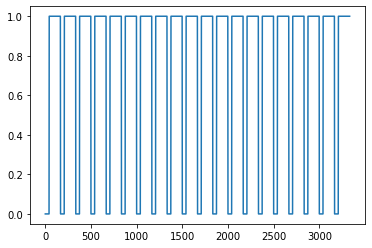

In [53]:
# First determine how to split the data into train and test sets
# *** use interleaved segments ***
nsegs = 20
nlen  = nt/nsegs
ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
itrain = np.ones(nt, np.bool)
itrain[itest] = 0

plt.plot(itrain)
plt.show()



Can you determine how I did the split above? Why might I have split into segments rather than randomly interleaving time-points?

# Regression

Now use linear regression to perform the prediction, predict $Y$ using $X$:

$$ A = (X_\text{train}X_\text{train}^\top)^{-1} (X_\text{train} Y_\text{train}^\top)$$

In [46]:
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp_linear = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

# Ridge Regression

If you want to regularize the linear regression:

$$ A = (X_\text{train}X_\text{train}^\top + \lambda I)^{-1} (X_\text{train} Y_\text{train}^\top)$$

Then the prediction on time points is:

$$ \hat Y_\text{test} = A^\top X_\text{test} $$

In [43]:
#### PREDICT USING BEHAVIOR PC'S 

## regularized linear regression from behavior to neural PC's
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e6 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V[:,itrain].T))

Vpred = np.matmul(A.T, beh[:,itest])

varexp_ridge = 1 - ((Vpred - V[:,itest])**2).sum(axis=1)/(V[:,itest]**2).sum(axis=1)

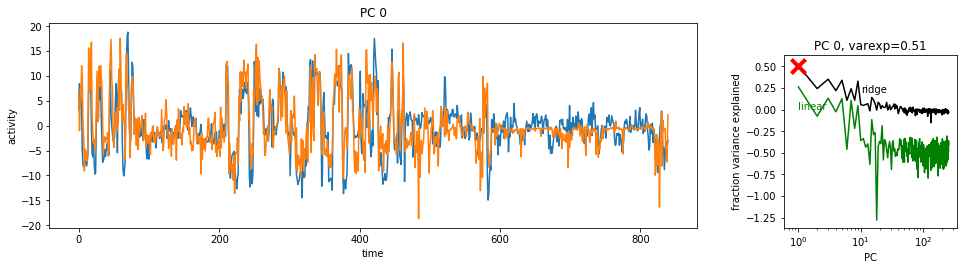

In [54]:
# plot of principal component activity and variance explained

fig=plt.figure(figsize=(12,3))

ipc = 0 ### which PC to plot

ax = fig.add_axes([0.05,.05,.75,.95])
ax.plot(V[ipc,itest])
ax.plot(Vpred[ipc])
ax.set_title('PC %d'%ipc)
ax.set_xlabel('time')
ax.set_ylabel('activity')

ax = fig.add_axes([0.9,.05, .2, .8])
ax.semilogx(np.arange(1,varexp.size+1), varexp_ridge, color='k')
ax.scatter(ipc+1, varexp_ridge[ipc],marker='x',color='r',s=200, lw=4, zorder=10)
ax.semilogx(np.arange(1,varexp_ridge.size+1), varexp_linear, color=[0.,.5,0])
ax.text(1,0,'linear',color=[0,.5,0])
ax.text(10,0.2,'ridge')
ax.set_xlabel('PC')
ax.set_ylabel('fraction variance explained')
ax.set_title('PC %d, varexp=%0.2f'%(ipc,varexp_ridge[ipc]))
plt.show()